In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

In [4]:
import os, sys

### Load Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_path = 'animal_dataset_intermediate'

In [7]:
!unzip "drive/My Drive/Colab Notebooks/dataset/animal_dataset_intermediate.zip"

Streaming output truncated to the last 5000 lines.
  inflating: animal_dataset_intermediate/train/farfalla_train/OIP-_z8BmGoaFisnSQGFyl0QSgHaFj.jpeg  
   creating: animal_dataset_intermediate/train/mucca_train/
  inflating: animal_dataset_intermediate/train/mucca_train/OIP---lAIbDlHKmejDpqrXq6vAAAAA.jpeg  
  inflating: animal_dataset_intermediate/train/mucca_train/OIP--8_E2EnxrYh7eym5nYRTJQHaE7.jpeg  
  inflating: animal_dataset_intermediate/train/mucca_train/OIP--anpNxrwGqisnmmTQUNgzgHaFj.jpeg  
  inflating: animal_dataset_intermediate/train/mucca_train/OIP--aZkgJekoo6fjs3pfBRsBAHaE8.jpeg  
  inflating: animal_dataset_intermediate/train/mucca_train/OIP--c6Kv6abukQvmc3gYdKvLwHaFS.jpeg  
  inflating: animal_dataset_intermediate/train/mucca_train/OIP--DTVnqj-HKjAEvLxZyOYGQHaFP.jpeg  
  inflating: animal_dataset_intermediate/train/mucca_train/OIP--DXIif9VVeC-pa14I8PQZgHaE6.jpeg  
  inflating: animal_dataset_intermediate/train/mucca_train/OIP--e77uBraw9yR8NL4ATG1TAHaE8.jpeg  
  inflating: 

In [8]:
# train_set = shuffle(pd.read_csv('face_mask_detection/Training_set_face_mask.csv'))
test_set = pd.read_csv(data_path+'/Testing_set_animals.csv')

In [9]:
test_set.head()

,filename,target
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,NaN
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,NaN
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,NaN
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,NaN
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,NaN


Generate train set animals csv

In [10]:
train_set = {
    'filename': [],
    'label': []
}
dir_train = data_path + '/train'

for _, folder in enumerate(os.listdir(dir_train)):
    dir_train_img = dir_train+'/'+folder
    target_name = folder.split('_')[0]
    for _, filename in enumerate(os.listdir(dir_train_img)):
        train_set['filename'].append(filename)
        train_set['label'].append(target_name)

train_set = pd.DataFrame(train_set)

In [11]:
train_set.head()

,filename,label
0,OIP-LOUpuM6ap83Lmosb_cCVLgHaFj.jpeg,pecora
1,OIP-Jj721fob4Q8UrkIEAN91_wEsDh.jpeg,pecora
2,OIP-DnSV_9VzsAn65-ImWShrVAHaDj.jpeg,pecora
3,OIP-fbzIyOJWRiND3nl6M8dbsQHaHa.jpeg,pecora
4,OIP-OYZPvbStzYajHxp6AgjSQQHaFj.jpeg,pecora


In [12]:
train_set.tail()

,filename,label
8193,OIP-eOuoCsdfcco8OgTLQgyFtwHaE7.jpeg,elefante
8194,OIP-qvBmW-hOt9dRo7JhB9JChgHaE8.jpeg,elefante
8195,OIP-py5EGqfcY95G2hYrxIayXwHaED.jpeg,elefante
8196,OIP-pZTeF1ca-j7NwecmK-cEAAHaEs.jpeg,elefante
8197,OIP-t4ZQXGwFfaaQIW7xpdXd8QHaDw.jpeg,elefante


In [13]:
train_set = shuffle(train_set).reset_index(drop=True)
train_set.head()

,filename,label
0,OIP-bR0buSrrEr5tok2Z6XQfgAHaEK.jpeg,pecora
1,OIP-VVQfbbfUJu2lp8id2v2NzAHaF7.jpeg,scoiattolo
2,OIP-w8cbkQk4LPLrJpjnXHXICgHaFV.jpeg,mucca
3,OIP-T7YRHYvnFCfO_Tqd--8ECQHaGR.jpeg,scoiattolo
4,OIP-p7bCeBK8LqKPGHh_9KhGOwHaGF.jpeg,farfalla


In [14]:
train_set.tail()

,filename,label
8193,OIP-SBxaCZ1CjA20QtHNYs01FAHaJr.jpeg,scoiattolo
8194,OIP-IMEtSmTwPpQ58j11NshumgHaE6.jpeg,mucca
8195,OIP-iH6nYMMACmM2sfEePZNSMQHaE5.jpeg,pecora
8196,OIP-IXg185PBsUiy2gDXcNmNZwHaE7.jpeg,scoiattolo
8197,OIP-AqQfFyxS3j2xeelkWeYAvwAAAA.jpeg,pecora


### Directory Preparation

Label Encoder

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
enc = LabelEncoder()
train_set['label'] = enc.fit_transform(train_set['label'])
train_set.head()

,filename,label
0,OIP-bR0buSrrEr5tok2Z6XQfgAHaEK.jpeg,3
1,OIP-VVQfbbfUJu2lp8id2v2NzAHaF7.jpeg,4
2,OIP-w8cbkQk4LPLrJpjnXHXICgHaFV.jpeg,2
3,OIP-T7YRHYvnFCfO_Tqd--8ECQHaGR.jpeg,4
4,OIP-p7bCeBK8LqKPGHh_9KhGOwHaGF.jpeg,1


Train / Validation Split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_set = train_set.filename.values
y_set = train_set.label.values

In [19]:
X_train_set, X_valid_set, y_train_set, y_valid_set = train_test_split(X_set, y_set, test_size=0.2, stratify=y_set, random_state=1)

In [20]:
train_set_df = pd.DataFrame({
    'filename': X_train_set,
    'label': y_train_set
}, index=X_train_set)

In [21]:
valid_set_df = pd.DataFrame({
    'filename': X_valid_set,
    'label': y_valid_set
}, index=X_valid_set)

In [22]:
train_set_df.head()

,filename,label
ea37b40b2cf0073ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg,ea37b40b2cf0073ed1584d05fb1d4e9fe777ead218ac10...,1
OIP-MPG7JqzIzRysH5J_cKu0lgHaE8.jpeg,OIP-MPG7JqzIzRysH5J_cKu0lgHaE8.jpeg,1
OIP-LLa9kY6X8Hx12LlhfEX57gHaFj.jpeg,OIP-LLa9kY6X8Hx12LlhfEX57gHaFj.jpeg,0
OIP-lLg_IuhbE0EJUvHLY-gUiwHaFj.jpeg,OIP-lLg_IuhbE0EJUvHLY-gUiwHaFj.jpeg,0
OIP--OHe3g7Mp_Gkr7nCer7fpAHaEy.jpeg,OIP--OHe3g7Mp_Gkr7nCer7fpAHaEy.jpeg,2


In [23]:
valid_set_df.head()

,filename,label
OIP-x8UREud4Xv9ZLKcjGlvdGgHaFc.jpeg,OIP-x8UREud4Xv9ZLKcjGlvdGgHaFc.jpeg,3
OIP-32p2dj_NNadM0ODM7YEZmwHaEK.jpeg,OIP-32p2dj_NNadM0ODM7YEZmwHaEK.jpeg,3
OIP-Xt-AuqdJUAX20roecYTF1QHaE8.jpeg,OIP-Xt-AuqdJUAX20roecYTF1QHaE8.jpeg,4
OIP-YPoSjLn0qIlVNoV7SCk6VwHaFi.jpeg,OIP-YPoSjLn0qIlVNoV7SCk6VwHaFi.jpeg,2
OIP-sjZPMzWql_GD8dw6m3eC7wHaGa.jpeg,OIP-sjZPMzWql_GD8dw6m3eC7wHaGa.jpeg,2


Rename files with giving their labels

In [25]:
dir = data_path + '/train/'
for _, folder in enumerate(os.listdir(dir)):
    dir_img = dir+folder+'/'
    for _, filename in enumerate(os.listdir(dir_img)):
        try:
            new_filename = dir_img + str(train_set_df.loc[filename]['label']) + '_train_' + filename
            os.rename(dir_img+filename, new_filename)
        except:
            new_filename = dir_img + str(valid_set_df.loc[filename]['label']) + '_valid_' + filename
            os.rename(dir_img+filename, new_filename)

Structured Directory

In [26]:
enc.classes_

array(['elefante', 'farfalla', 'mucca', 'pecora', 'scoiattolo'],
      dtype=object)

In [27]:
!mkdir data

In [28]:
!mkdir data/train
!mkdir data/test

!mkdir data/train/0
!mkdir data/train/1
!mkdir data/train/2
!mkdir data/train/3
!mkdir data/train/4

!mkdir data/test/0
!mkdir data/test/1
!mkdir data/test/2
!mkdir data/test/3
!mkdir data/test/4

In [29]:
!mv animal_dataset_intermediate/train/elefante_train/0_train*.jp*g data/train/0
!mv animal_dataset_intermediate/train/farfalla_train/1_train*.jp*g data/train/1
!mv animal_dataset_intermediate/train/mucca_train/2_train*.jp*g data/train/2
!mv animal_dataset_intermediate/train/pecora_train/3_train*.jp*g data/train/3
!mv animal_dataset_intermediate/train/scoiattolo_train/4_train*.jp*g data/train/4

!mv animal_dataset_intermediate/train/elefante_train/0_valid*.jp*g data/test/0
!mv animal_dataset_intermediate/train/farfalla_train/1_valid*.jp*g data/test/1
!mv animal_dataset_intermediate/train/mucca_train/2_valid*.jp*g data/test/2
!mv animal_dataset_intermediate/train/pecora_train/3_valid*.jp*g data/test/3
!mv animal_dataset_intermediate/train/scoiattolo_train/4_valid*.jp*g data/test/4

In [30]:
train_path = 'data/train'
valid_path = 'data/test'

In [31]:
IMG_SIZE = [200, 200]

In [32]:
from glob import glob

In [33]:
train_img_files = glob(train_path + '/*/*.jp*g')
valid_img_files = glob(valid_path + '/*/*.jp*g')

In [34]:
train_folders = glob(train_path + '/*')
train_folders

['data/train/4',
 'data/train/0',
 'data/train/1',
 'data/train/3',
 'data/train/2']

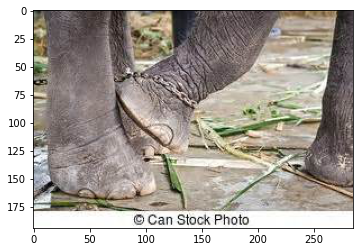

In [39]:
plt.imshow(image.load_img('data/train/0/0_train_OIP---LeldVL441fx5S66TGgVQAAAA.jpeg'))
plt.show()

### Model Train

#### Pre Trained Model

In [40]:
ptm = PretrainedModel(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + [3]
)

58892288/58889256 [==============================] - 0s 0us/step


In [41]:
ptm.trainable=False

#### Without Data Augmentation

In [42]:
dx = Flatten()(ptm.output)
dm = Model(inputs=ptm.input, outputs=dx)

In [43]:
dm.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

Data Generator without data augmentation

In [63]:
gend = ImageDataGenerator(preprocessing_function=preprocess_input)

In [64]:
batch_size = 64
train_gend = gend.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='sparse'
)

valid_gend = gend.flow_from_directory(
    valid_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 6531 images belonging to 5 classes.
Found 1631 images belonging to 5 classes.


In [65]:
# define shape of train and valid data after pre trained model
N_train = len(train_img_files)
N_valid = len(valid_img_files)

feat = dm.predict(np.random.random([1]+ IMG_SIZE+ [3]))
D = feat.shape[1]

Xd_train = np.zeros((N_train, D))
yd_train = np.zeros(N_train)
Xd_valid = np.zeros((N_valid, D))
yd_valid = np.zeros(N_valid)

In [66]:
i = 0
for x, y in train_gend:
    # get features
    features = dm.predict(x)

    # size of batch
    sz = len(y)

    Xd_train[i:i+sz] = features
    yd_train[i:i+sz] = y

    i += sz
    print(i)

    if i >= N_train:
        print('stop now') # after train length achieved stop populate data or it will be looping forever
        break
print(i)

64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3072
3136
3200
3264
3328
3392
3456
3520
3584
3648
3712
3776
3840
3904
3968
4032
4096
4160
4224
4288
4352
4416
4480
4544
4608
4672
4736
4800
4864
4928
4992
5056
5120
5184
5248
5312
5376
5440
5504
5568
5632
5696
5760
5824
5888
5952
6016
6080
6144
6208
6272
6336
6400
6464
6528
6531
stop now
6531


In [67]:
Xd_train.shape

(6531, 18432)

In [68]:
i = 0
for x, y in valid_gend:
    # get features
    features = dm.predict(x)

    # size of batch
    sz = len(y)

    Xd_valid[i:i+sz] = features
    yd_valid[i:i+sz] = y

    i += sz
    print(i)

    if i >= N_valid:
        print('stop now') # after valid length achieved stop populate data or it will be looping forever
        break
print(i)

64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1631
stop now
1631


In [69]:
Xd_valid.shape

(1631, 18432)

Normalize Data

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
scaler = StandardScaler()
Xd_train = scaler.fit_transform(Xd_train)
Xd_valid = scaler.transform(Xd_valid)

Train Data

Traditional Machine Learning Classification Model

In [72]:
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

In [74]:
rf = RandomForestClassifier(criterion='entropy', max_leaf_nodes=20, oob_score=True, n_jobs=-1)
rf.fit(Xd_train, yd_train)
print(f'Random Forest Train Score: {rf.score(Xd_train, yd_train)}')
print(f'Random Forest Validation Score: {rf.score(Xd_valid, yd_valid)}')

Random Forest Train Score: 0.891134588883785
Random Forest Validation Score: 0.8835070508890251


In [76]:
# xgb = XGBClassifier()
# xgb.fit(Xd_train, yd_train)
# print(f'XGBoost Train Score: {xgb.score(Xd_train, yd_train)}')
# print(f'XGBoost Validation Score: {xgb.score(Xd_valid, yd_valid)}')

KeyboardInterrupt: ignored

NN

In [77]:
i = Input(shape=(D,))
x = Dense(len(train_folders), activation='softmax')(i)

In [78]:
model = Model(i, x)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 18432)]           0         
_________________________________________________________________
dense (Dense)                (None, 5)                 92165     
Total params: 92,165
Trainable params: 92,165
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [80]:
r = model.fit(Xd_train, yd_train, epochs=20, batch_size=128, validation_data=(Xd_valid, yd_valid))

Epoch 1/20
52/52 [==============================] - 0s 9ms/step - loss: 0.2800 - accuracy: 0.9066 - val_loss: 0.1501 - val_accuracy: 0.9516
Epoch 2/20
52/52 [==============================] - 0s 7ms/step - loss: 0.0466 - accuracy: 0.9864 - val_loss: 0.1573 - val_accuracy: 0.9601
Epoch 3/20
52/52 [==============================] - 0s 6ms/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.1499 - val_accuracy: 0.9589
Epoch 4/20
52/52 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1490 - val_accuracy: 0.9608
Epoch 5/20
52/52 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.9595
Epoch 6/20
52/52 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1553 - val_accuracy: 0.9608
Epoch 7/20
52/52 [==============================] - 0s 6ms/step - loss: 9.6463e-04 - accuracy: 1.0000 - val_loss: 0.1547 - val_accuracy: 0.9595
Epoch 8/20
52/52

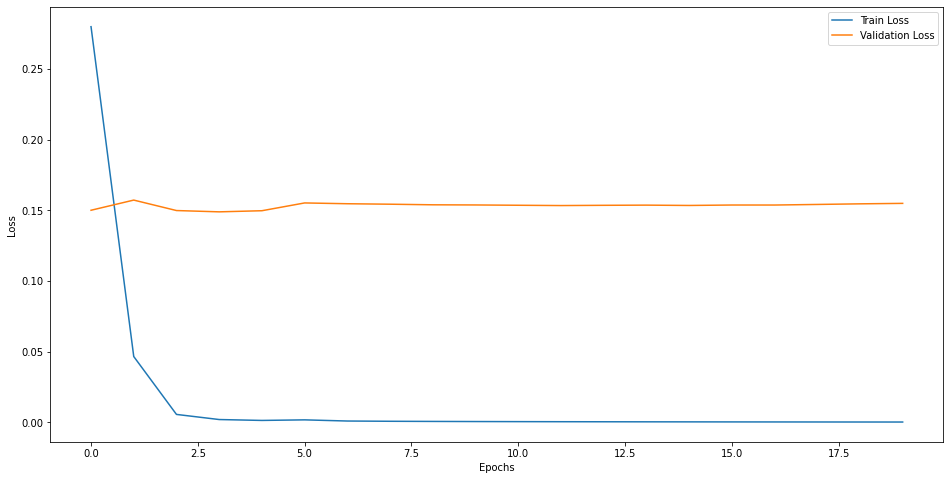

In [81]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

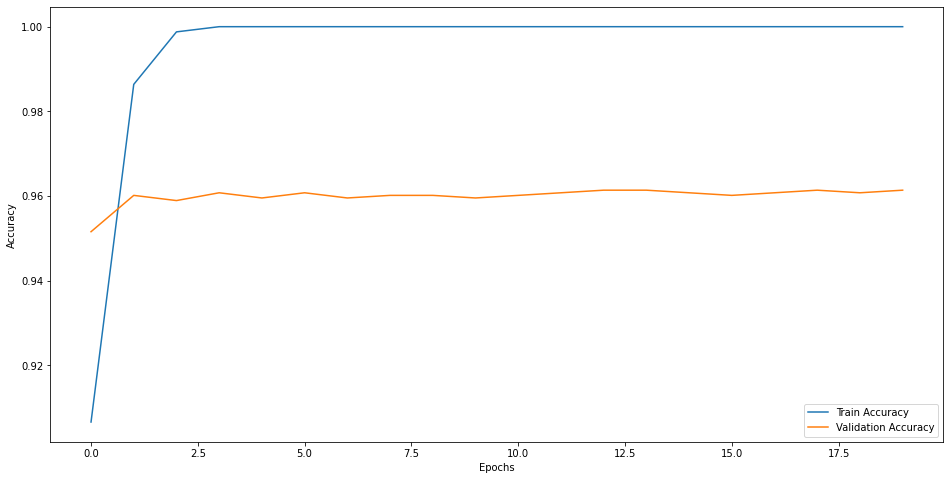

In [82]:
plt.figure(figsize=(16, 8))
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Predictions

NN Without Data Augmentation

In [89]:
test_set_df = pd.DataFrame({
    'filename': test_set['filename'].values,
    'animal_type': test_set['target'].values
}, index=test_set['filename'].values)

In [90]:
y_preds = []
test_path = data_path+'/test/'
for f in test_set_df['filename']:
    filename = test_path + f
    img = image.load_img(filename, target_size=IMG_SIZE)
    img = image.img_to_array(img)
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    img = preprocess_input(img)

    feat_test = dm.predict(img)
    feat_test = scaler.transform(feat_test)
    y_pred = model.predict(feat_test).argmax(axis=1)
    y_preds.append(y_pred)

In [92]:
test_set_df['animal_type'] = enc.inverse_transform(y_preds)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [93]:
test_set_df.head()

,filename,animal_type
e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg,e030b20928e90021d85a5854ee454296eb70e3c818b413...,farfalla
e030b20929e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg,e030b20929e90021d85a5854ee454296eb70e3c818b413...,farfalla
e030b2092be90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg,e030b2092be90021d85a5854ee454296eb70e3c818b413...,farfalla
e030b2092ce90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,farfalla
e030b2092de90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg,e030b2092de90021d85a5854ee454296eb70e3c818b413...,farfalla


Sample Plot

farfalla


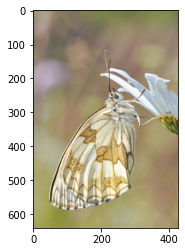

In [94]:
test_img = 'e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg'
print(test_set_df.loc[test_img]['animal_type'])
plt.imshow(image.load_img(test_path + test_img))
plt.show()

In [ ]:
result_df = pd.DataFrame({
    'prediction': test_set_df['label'].values
})
result_df.to_csv('fmd_result.csv', index=False)

In [95]:
from google.colab import files 

In [96]:
test_set_df.to_csv('ra_result.csv', index=False)
       
files.download('ra_result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>